In [1]:
# Here we import database we will need later
import torch    # Basic PyTorch library for tensor operations
import torch.nn as nn   # Building Neural Networks
import torch.nn.functional as F # Activation functions and other utilities
from torch_geometric_temporal.nn.recurrent import A3TGCN    # See below
from torch_geometric_temporal.dataset import METRLADatasetLoader    # Load the dataset
from torch_geometric.loader import DataLoader  # For batching and loading data
from tqdm import tqdm   # The visualization of processing progress
import matplotlib.pyplot as plt # For basic visualization
import seaborn as sns  # For advanced visualization
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis that i am familiar with

/Users/duhaolei/my-pytorch-project/torch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Now, we will load the METR-LA dataset and see what is inside
loader = METRLADatasetLoader()
# We will take the data from the time span of before 60 min to after 60 min
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

100%|██████████| 13.6M/13.6M [00:33<00:00, 426kB/s]


#### Here we will config a simple GNN model

#### In this version, now there is one important concept added: 
There are different types of "edges" in traffic circumstances: 

    Free Flow: the traffic can move forward, this is a "Downstream" edge
    
    Congestion: there is a backward traffic shock wave. This is an "Upstream" edge. 


In [27]:
class TemporalGNN(nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN,self).__init__()
        # Here we will use A3TGCN (mentioned above) as our temporal GNN layer

        # DIFFERENT From before, now we will design two A3TGCN and combine them together. 
        self.tgnn_down = A3TGCN(in_channels=node_features,out_channels=32,periods=periods)
        
        self.tgnn_up = A3TGCN(in_channels=node_features,out_channels=32,periods=periods)

        self.linear = nn.Linear(32, 12)

    def forward(self,x,edge_index,edge_weight):
        # Now before everything in this message passing & aggregation function
        # we will classify nodes into "upstream" and "downstream"
        # The default is "upstream"
        edge_index_down = edge_index

        # Now we will define the "upstream" -- Backward -- revserse
        edge_index_up = torch.stack([edge_index[1],edge_index[0]],dim=0)

        # Below will be the excution 

        h_down = self.tgnn_down(x,edge_index_down,edge_weight)

        h_up = self.tgnn_up(x,edge_index_up,edge_weight)
        # ReLU is the modeling phase transition in this traffic prediction context
        # WHY? -- a linear model cannot learn from the rapid and sharp changes in traffic conditions
        # ReLU introduces non-linearity, allowing the model to capture complex patterns and sudden shifts in traffic data

        # simple sum aggregation of up and down
        h = h_up + h_down 
        h = F.relu(h)

        # Final prediction
        h = self.linear(h)
        return h

In [28]:
# INstead of training overr and over again while the error is fluctuating but not decreasing.
# the training should also learn how to stop

class EarlyStopper:
    # patience here means is the result is not improving 
    # __init__ is the fixed name of Constructor, which means initialization
    # self literally means "myself"
    # Also, here the min_delta means the expected minumum improvement, 
    # the drop of error must be bigger than this value, then the drop will be counted as a True
    def __int__(self,patience=5,min_delta=0):
    
        self.patience = patience 
        self.min_delta = min_delta

        self.counter = 0

        self.min_validation_loss = np.inf
    
    def early_stop(self,validation_loss):

        # This is when the model made improvements
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self_counter = 0    # We dont count it as a step without improvemetens
            return False
        
        # But when the model started to not make improvements
        elif validation_loss > (self.min_valication_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

#### After the model is initially configured, we will train it. 

In [29]:
# Setup the device for computation
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
PIN_MEMORY=True

In [30]:
# Now we can no longer simply use all the data to train
# Here we will apply split
full_data = list(dataset)

# Split logic: 80% train, 20% validation

split_index = int(len(full_data) * 0.8)
train_dataset = full_data[:split_index]
val_dataset = full_data[split_index:]

train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True,
                          pin_memory=True)
val_loader = DataLoader(val_dataset,batch_size=16,shuffle=True,
                          pin_memory=True)



In [10]:
torch.mps.empty_cache()
model = TemporalGNN(node_features=2,periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)    # Manually setup learning rate of Gradient Descent optimizer as 0.01
loss_fn = torch.nn.L1Loss()

early_stopper = EarlyStopper()

print(f'Starting training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples...')


for epoch in range(1,51):   # Train for 20 epochs
    epoch_loss = 0
    step = 0
    progressor = tqdm(train_loader,desc=f'Epoch {epoch:02d}',leave=False)
    model.train()
    for batch in progressor:
        batch = batch.to(device)

        optimizer.zero_grad()
        # This is how we get the prediction from the model

        y_hat = model(batch.x, batch.edge_index, batch.edge_attr)

        # Here we calculate the loss between the prediction and the ground truth
        # INITIALLY TRIAL i use MSE, but soon i will use more feasible method here
        loss = loss_fn(y_hat, batch.y)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent exploding gradients

        optimizer.step()
        epoch_loss += loss.item()
        step += 1

    avg_loss = epoch_loss / step

    # Now below is the added evaluation part

    model.eval()
    val_loss = 0
    val_step = 0
    progressor2 = tqdm(val_loader,desc=f'Epoch {epoch:02d}',leave=False)
    with torch.no_grad():   # We have to disable the gradient calculation
        for batch in val_loader:

            batch = batch.to(device)
            y_hat = model(batch.x, batch.edge_index, batch.edge_attr)
            loss = loss_fn(y_hat,batch.y)

            val_loss += loss.item()

            val_step += 1
    
    avg_val_loss = val_loss / val_step

    print(f'Epoch {epoch:02d} | Train MAE: {avg_loss:.4f} | Val MAE: {avg_val_loss:.4f}')

    if early_stopper.early_stop(avg_val_loss): 
        print(f'Early stopping is triggered.\nThe training stops at Epoch {epoch}')
        break


print('Training process finished.')

Starting training on 27399 samples, validating on 6850 samples...


KeyboardInterrupt: 

#### Here comes to my stage review?
Where did we change? 
- The classification of adjacency matrix. We learnt how to deal with the heterogenous GNN, which in this circumstance indicate "upstream" and "downstream", two kinds of edge type.

- The evaluation system. At the last raw edition, the error kept fluctuating and didnt see a decrease for a while. After studying, i learnt that the "early stopping" mechanism. So here we design the earlystop model and apply trian-validation split on the dataset. 

Why this matters? 
- In our traffic prediction, we are also trying to avoide overfitting -- when the training loss is decreasing but the validation loss is increasing. We have to tell the model, how to stop in time. 

#### After training, lets see the result
*Early stop actually worked*

In [2]:
result = pd.read_csv('result-v2.csv')
result.head()

,Epoch,Train MAE,Val MAE
0,1,0.3345,0.3524
1,2,0.3213,0.3532
2,3,0.3190,0.3521
3,4,0.3180,0.3475
4,5,0.3173,0.3487


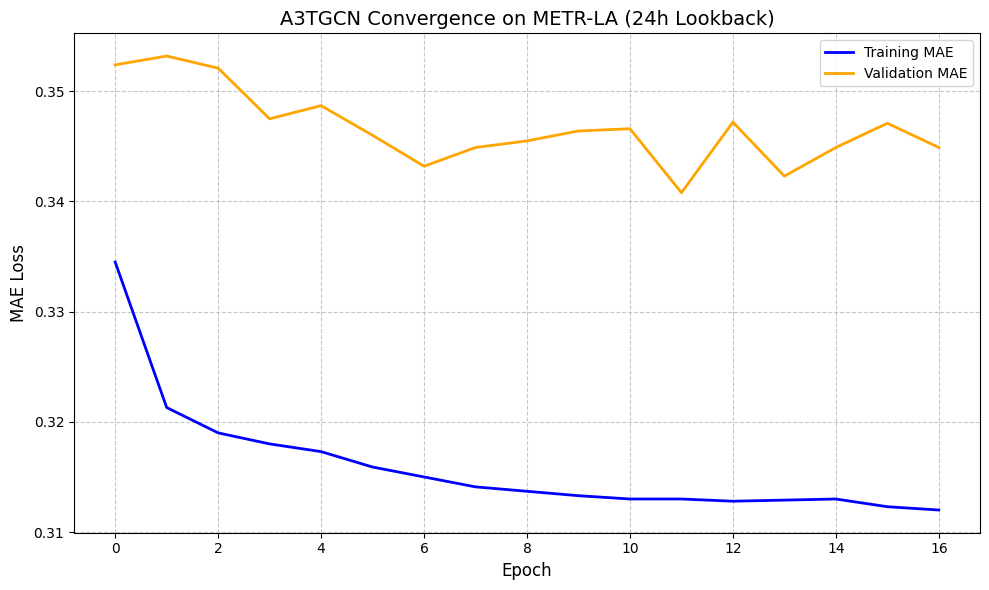

In [3]:
# Now let's visualize the result (codes copied from version one)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(result['Train MAE'], label='Training MAE', color='blue', linewidth=2)
plt.plot(result['Val MAE'], label='Validation MAE', color='orange', linewidth=2)

plt.title('A3TGCN Convergence on METR-LA (24h Lookback)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend() # This will show the labels defined above
plt.tight_layout()
plt.show()

In [1]:
0.003*13.7*53.7

2.20707

#### Interetation and Reflection
1. What does the plot above say?
- The blue line of training loss is descending steadily, indicating the fact that the model sucessfully learnt the heterougenous types -- upstream and downstream.

    Also, the overall error value is smaller compared to the version 1 result. We made a progress!

- The validation loss value is fluctuating intensively somtimes, which means in some splitted validation dataset there are some unusal traffic situation (congestion...). But it was still going down. 

- What's more, there is an approximately 0.03 value difference. This is so called the *Generalization Error*. Let's check it out in real life: $$Deviation_{standard}=µ=13.7 mph$$ $$Speed_{mean}=\sigma=53.7 mph$$
$$Deviation_{here}=0.03\times µ \times \sigma=2.21 mph$$

# A BIG PROBLEM OCCUR
## When we actually take a look at the real speed - prediction, there is something wrong!!!

In [21]:
Error_log = pd.read_csv("training_log.csv")
Error_log.head()

,time_step,ground_truth,prediction
0,0,0.795008,0.205678
1,1,0.597084,0.206457
2,2,0.811501,0.208476
3,3,-0.029672,0.187955
4,4,-1.085262,0.183828


In [22]:
# Now we will transform the data into real world speed. 
MEAN_SPEED = 53.599
STD_SPEED = 20.720

Error_log['ground_truth'] = (Error_log['ground_truth'] * STD_SPEED) + MEAN_SPEED
Error_log['prediction'] = (Error_log['prediction'] * STD_SPEED) + MEAN_SPEED

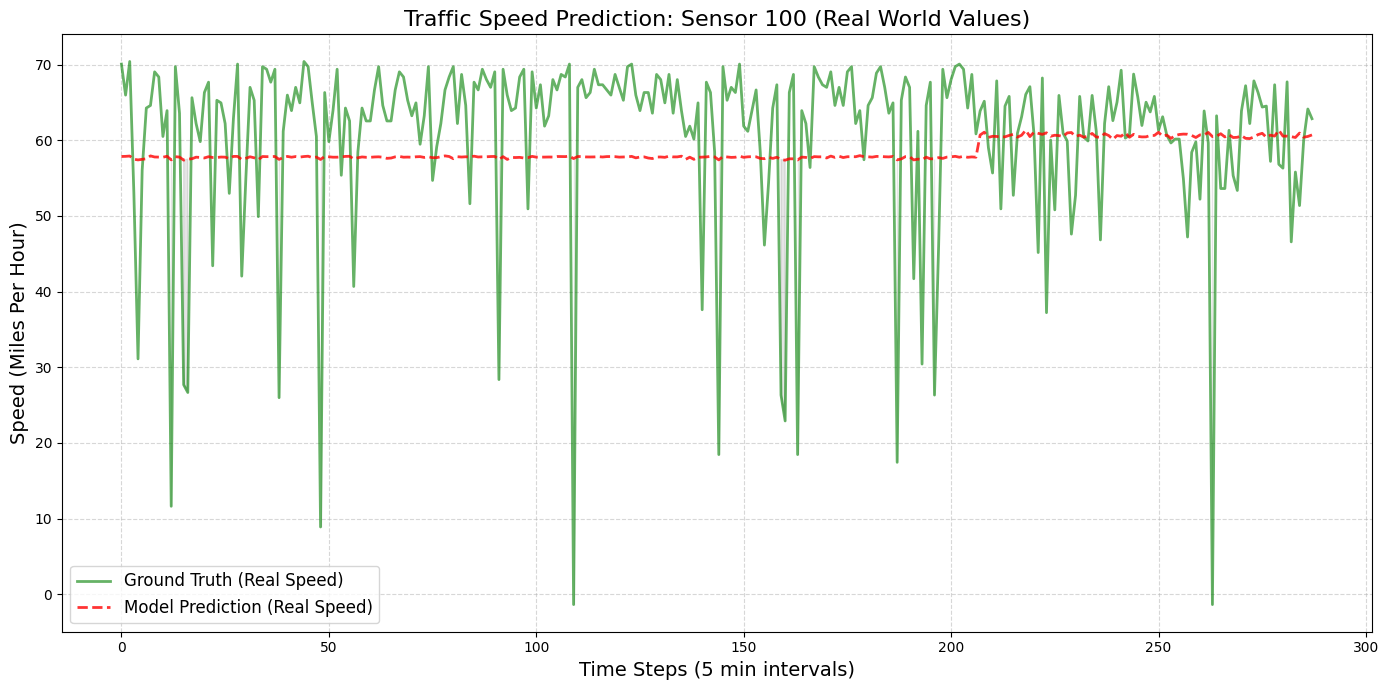

In [23]:
node_id = 100
plt.figure(figsize=(14, 7))

# Plot Real Speed
plt.plot(Error_log['ground_truth'],label='Ground Truth (Real Speed)', color='green', alpha=0.6, linewidth=2)
plt.plot(Error_log['prediction'], label='Model Prediction (Real Speed)', color='red', linestyle='--', alpha=0.8, linewidth=2)

plt.title(f'Traffic Speed Prediction: Sensor {node_id} (Real World Values)', fontsize=16)
plt.xlabel('Time Steps (5 min intervals)', fontsize=14)
plt.ylabel('Speed (Miles Per Hour)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Highlight Congestion (e.g., Speed < 30 mph)
# We use 30 mph as a standard "Congestion" threshold for freeways
plt.fill_between(range(len(Error_log['ground_truth'])), Error_log['ground_truth'], Error_log['prediction'], 
                 where=(Error_log['ground_truth'] < 30), color='gray', alpha=0.2, label='Congestion Zone (<30 mph)')

plt.tight_layout()
plt.show()

## From above plot, we can indicate that the model has its "LAZYNESS", it was not learning. Instead, it was merely trying to find a flat line. 
### So we will adopt different method and see what is going on. 

Starting Overfit Test on a SINGLE batch...
Epoch 10: Loss 0.4760
Epoch 20: Loss 0.4232
Epoch 30: Loss 0.4077
Epoch 40: Loss 0.4001
Epoch 50: Loss 0.3952
Epoch 60: Loss 0.3908
Epoch 70: Loss 0.3872
Epoch 80: Loss 0.3841
Epoch 90: Loss 0.3807
Epoch 100: Loss 0.3768


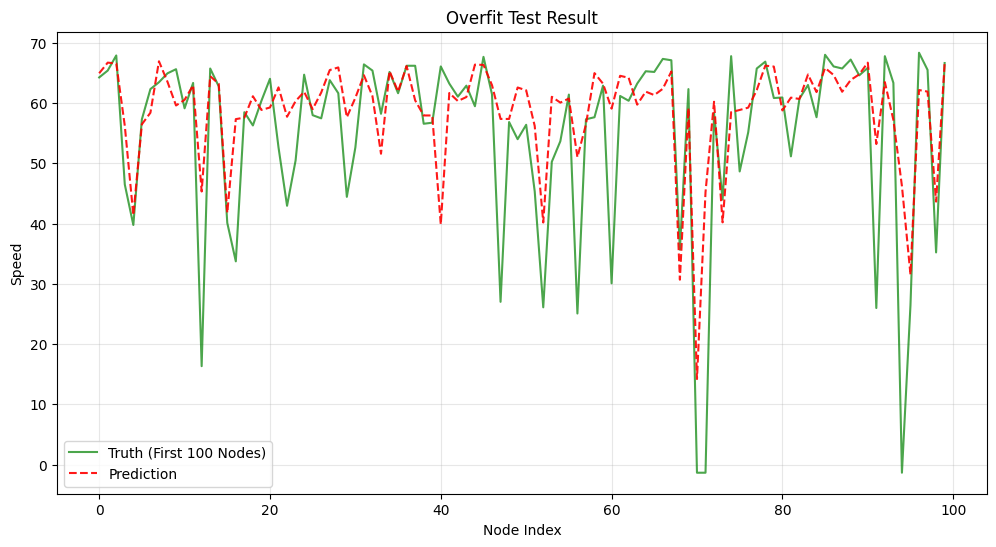

In [31]:
# for running time, here we take a single batch to test
single_batch = next(iter(train_loader))
single_batch = single_batch.to(device)

# initialize the model again
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
loss_fn = torch.nn.L1Loss()

print("Starting Overfit Test on a SINGLE batch...")

# a normal train loss record as usual
train_losses = []

for epoch in range(1, 101): # 100 epochs on the SAME data
    model.train()
    optimizer.zero_grad()
    
    # Predict on the same batch every time
    y_hat = model(single_batch.x, single_batch.edge_index, single_batch.edge_attr)
    loss = loss_fn(y_hat, single_batch.y)
    
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}")


model.eval()
with torch.no_grad():
    # 1. Get predictions
    y_pred = model(single_batch.x, single_batch.edge_index, single_batch.edge_attr)

    pred_cpu = y_pred.cpu().numpy()[:, 0]  
    truth_cpu = single_batch.y.cpu().numpy()[:, 0]

    pred_cpu = (pred_cpu * STD_SPEED) + MEAN_SPEED
    truth_cpu = (truth_cpu * STD_SPEED) + MEAN_SPEED
    
    # 3. Plot only the first 100 nodes (to keep the graph readable)
    plt.figure(figsize=(12,6))
    plt.plot(truth_cpu[:100], label='Truth (First 100 Nodes)', color='green', alpha=0.7)
    plt.plot(pred_cpu[:100], label='Prediction', color='red', linestyle='--', alpha=0.9)
    
    plt.title("Overfit Test Result")
    plt.xlabel("Node Index")
    plt.ylabel("Speed")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

#### After the "Overfit Test", we can see that the model finally is going to predict the speed instead of keeping being lazy. 
#### But how does this overfitting work? 
- By removing the else batches and only keeping one, we actually decrease the Complexity of Training dramatically. For a single batch, the model is able to memorrize the pattern easily. 

#### Reminder: 
- The model is able to learn by itself. Without rerun the model initialization cell. If i run the training cell over and over again,the model will learn the physics pattern of the data. 
- We should not do sth like this. 